# First Year Project
## Project 1 - Road Collissions Analysis, ITU Copenhagen

This notebook contains all of the code developed for project 1, to explore the data set of Road Collisions from UK.gov with a focus on the city of Birmingham.

Nicola (niccl@itu.dk)<br>
Emma (@itu.dk)<br>
Karlis (@itu.dk)<br>
Kirstine (@itu.dk)<br>
Danielle (ddeq@itu.dk)<br>

Created: 12-02-2021
<br>Last modified: 12-02-2021

## Imports

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Constants

In [37]:
PATH = {}
PATH["data_raw"] = "../Data/raw/"
PATH["data_interim"] = "../Data/interim/"
PATH["data_processed"] = "../Data/processed/"
PATH["data_external"] = "../Data/external/"

FILENAME = {}
FILENAME["accidents"] = "Road Safety Data - Accidents 2019.csv"
FILENAME["casualties"] = "Road Safety Data - Casualties 2019.csv"
FILENAME["vehicles"] = "Road Safety Data- Vehicles 2019.csv" 

TABLENAMES = ["accidents", "casualties", "vehicles"]

## Load raw data

The data were downloaded from here on Jan 4th: https://data.gov.uk/dataset/road-accidents-safety-data
That page was updated afterwards (Jan 8th), so local and online data may be inconsistent.

In [38]:
dataraw = {}
dataraw["accidents"] = np.genfromtxt(PATH["data_raw"]+FILENAME["accidents"], delimiter=',', dtype=None, names=True, encoding='utf-8-sig')
dataraw["vehicles"] = np.genfromtxt(PATH["data_raw"]+FILENAME["vehicles"], delimiter=',', dtype=None, names=True, encoding='utf-8-sig')
dataraw["casualties"] = np.genfromtxt(PATH["data_raw"]+FILENAME["casualties"], delimiter=',', dtype=None, names=True, encoding='utf-8-sig')

In [39]:
# Get a dictionary of the variable names for each table
variable_names_raw = {}
for variable_name in TABLENAMES:
    variable_names_raw[variable_name] = list(dataraw[variable_name].dtype.names)

In [40]:
#variable_names_raw["accidents"]

In [41]:
#dataraw["accidents"][:5]

## Report the dimensions of the data (number of tables, rows, fields).

We have 3 tables: Accidents, Casualites, and Vehicles data tables.

### Number of records in each table

In [42]:
print(f"Number of records in accident table: {dataraw['accidents'].shape}")
print(f"Number of records in vehicles table: {dataraw['vehicles'].shape}")
print(f"Number of records in casualties table: {dataraw['casualties'].shape}")

Number of records in accident table: (117536,)
Number of records in vehicles table: (216381,)
Number of records in casualties table: (153158,)


### Number of fields in each table

In [43]:
print(f"Number of fields in the accident table: {len(dataraw['accidents'].dtype)}")
print(f"Number of fields in the vehicles table: {len(dataraw['vehicles'].dtype)}")
print(f"Number of fields in the casualties table: {len(dataraw['casualties'].dtype)}")

Number of fields in the accident table: 32
Number of fields in the vehicles table: 23
Number of fields in the casualties table: 16


In [44]:
#dataraw["accidents"]["Local_Authority_District"]

### Checking IDs

In [45]:
raw_accident_AI=dataraw["accidents"]["Accident_Index"]
raw_vehicles_AI=dataraw["vehicles"]["Accident_Index"]
raw_casualties_AI=dataraw["casualties"]["Accident_Index"]
#print(#memeber of raw_vehicles_ids and not raw_acidents_its)
mask_missing_c_AI = np.where(np.isin(dataraw["casualties"]["Accident_Index"], (raw_accident_AI)))
print("Number of accident IDs in the casualties data:",len(raw_casualties_AI),"\nNumber of IDs in the casualties data tha also appear in the accidents data:",len(raw_casualties_AI[mask_missing_c_AI]))
mask_missing_v_AI = np.where(np.isin(dataraw["vehicles"]["Accident_Index"], (raw_accident_AI)))
print("Number of accident IDs in the vehicles data:",len(raw_vehicles_AI),
      "\nNumber of IDs in the cvehicles data tha also appear in the accidents data:",
      len(raw_vehicles_AI[mask_missing_v_AI]))

Number of accident IDs in the casualties data: 153158 
Number of IDs in the casualties data tha also appear in the accidents data: 153158
Number of accident IDs in the vehicles data: 216381 
Number of IDs in the cvehicles data tha also appear in the accidents data: 216381


### Does every AccidentID in the casualties and vehicles tables have their corresponding AccidentID in the accident table?

Yes, after cleaning both the casualties and vehicles sheets to only have records where their accident ID is in the cleaned Birmingham accident sheet.

## Masking for Birmingham

Birmingham is listed as code "300" under the "Local_Authority_District" field. First we narrowed down the accidents table to only show records that match this code in that field.

In [46]:
# Create a dictionary to hold all of the clean data
data_bir = {}

# creating the mask to show the data for Birmingham on the accidents sheet
birmingham_mask = np.where(dataraw["accidents"]["Local_Authority_District"] == 300)
data_bir["accidents"] = dataraw["accidents"][birmingham_mask]

Then we narrowed down the casualties and vehicles sheets to only have records that would be reflected in the accident sheet, thereby having only records of that pertain to Birmingham.

In [47]:
# Create an array of the accident IDs related to Birmingham (use this to filter the other tables)
accident_ids = np.array(data_bir["accidents"]["Accident_Index"])

# Create a mask to filter casualties table based on the accident ids
casualties_mask = np.where(np.isin(dataraw["casualties"]["Accident_Index"], (accident_ids)))
data_bir["casualties"] = dataraw["casualties"][casualties_mask]

In [48]:
# Create a mask to filter vehicles table based on the accident ids
vehicles_mask = np.where(np.isin(dataraw["vehicles"]["Accident_Index"], (accident_ids)))
data_bir["vehicles"] = dataraw["vehicles"][vehicles_mask]

In [49]:
# An example of how we would save a copy of the processed data to the correct directory
#clean_accidents.to_csv(r'../Data/interim/clean_accidents.csv', index = False, header = True)
#np.savetxt(PATH["data_interim"] + "clean_accidents.csv", clean_accidents, delimiter=",")

## Identify for each variable whether it is numerical or categorical.

### Insight: Mixed variable types

Accidents have mixed data types, including strings, floats, and integers. Categorical variables are encoded as integers. The meaning of these categories can be looked up in: ../references/variable lookup.xls

In [50]:
# Number of entries in each table after being filtered to Birmingham

print(f"Number of records in Birmingham accident table: {data_bir['accidents'].shape}")
print(f"Number of records in Birmingham casualties table: {data_bir['casualties'].shape}")
print(f"Number of records in Birmingham vehicles table: {data_bir['vehicles'].shape}")

Number of records in Birmingham accident table: (2623,)
Number of records in Birmingham casualties table: (3551,)
Number of records in Birmingham vehicles table: (4962,)


We manually went through the variable lists to come up with which variables were categorical or numerical.

References<br>
what is categorical - http://www.stat.yale.edu/Courses/1997-98/101/catdat.htm <br>
the hell is LSOA - https://datadictionary.nhs.uk/nhs_business_definitions/lower_layer_super_output_area.html#:~:text=A%20Lower%20Layer%20Super%20Output,Lower%20Layer%20Super%20Output%20Areas
decile -http://mast.roadsafetyanalysis.org/wiki/index.php?title=Driver_IMD_Decile#:~:text=An%20IMD%20decile%20is%20a,the%2010%25%20least%20deprived%20areas.


Acidents <br><br>
Accident_Index  - Categorical<br>
Location_Easting_OSGR  - Numerical<br>
Location_Northing_OSGR  - Numerical<br>
Longitude  - Numerical<br>
Latitude  - Numerical<br>
Police_Force  - Categorical<br>
Accident_Severity  - Categorical<br>
Number_of_Vehicles  - Numerical<br>
Number_of_Casualties  - Numerical<br>
Date  - Numerical/Categorical<br>
Day_of_Week  - Categorical<br>
Time  - Numerical(but can be categorical)<br>
Local_Authority_(District)  - Categorical<br>
Local_Authority_(Highway)  - Categorical<br>
1st_Road_Class  - Categorical<br>
1st_Road_Number  - Categorical<br>
Road_Type  - Categorical<br>
Speed_limit  - Categorical(we questioned this)<br>
Junction_Detail  - Categorical<br>
Junction_Control  - Categorical<br>
2nd_Road_Class  - Categorical<br>
2nd_Road_Number  - Categorical<br>
Pedestrian_Crossing-Human_Control  - Categorical<br>
Pedestrian_Crossing-Physical_Facilities  - Categorical<br>
Light_Conditions  - Categorical<br>
Weather_Conditions  - Categorical<br>
Road_Surface_Conditions  - Categorical<br>
Special_Conditions_at_Site  - Categorical<br>
Carriageway_Hazards  - Categorical<br>
Urban_or_Rural_Area  - Categorical<br>
Did_Police_Officer_Attend_Scene_of_Accident  - Categorical<br>
LSOA_of_Accident_Location  - Categorical<br>

Vehicles<br><br>
Accident_Index  - Categorical<br>
Vehicle_Reference  - Categorical<br>
Vehicle_Type  - Categorical<br>
Towing_and_Articulation  - Categorical<br>
Vehicle_Manoeuvre  - Categorical<br>
Vehicle_Location-Restricted_Lane  - Categorical<br>
Junction_Location  - Categorical<br>
Skidding_and_Overturning  - Categorical<br>
Hit_Object_in_Carriageway  - Categorical<br>
Vehicle_Leaving_Carriageway  - Categorical<br>
Hit_Object_off_Carriageway  - Categorical<br>
1st_Point_of_Impact  - Categorical<br>
Was_Vehicle_Left_Hand_Drive?  - Categorical<br>
Journey_Purpose_of_Driver  - Categorical<br>
Sex_of_Driver  - Categorical<br>
Age_of_Driver  - Numerical<br>
Age_Band_of_Driver  - Categorical<br>
Engine_Capacity_(CC)  - Numerical<br>
Propulsion_Code  - Categorical(probably)<br>
Age_of_Vehicle  - Numerical<br>
Driver_IMD_Decile  - Categorical<br>
Driver_Home_Area_Type  - Categorical<br>
Vehicle_IMD_Decile  - Categorical<br>

Casualties <br><br>
Accident_Index  - Categorical<br>
Vehicle_Reference  - Categorical<br>
Casualty_Reference  - Categorical<br>
Casualty_Class  - Categorical<br>
Sex_of_Casualty  - Categorical<br>
Age_of_Casualty  - Numerical<br>
Age_Band_of_Casualty  - Categorical<br>
Casualty_Severity  - Categorical<br>
Pedestrian_Location  - Categorical<br>
Pedestrian_Movement  - Categorical<br>
Car_Passenger  - Categorical<br>
Bus_or_Coach_Passenger  - Categorical<br>
Pedestrian_Road_Maintenance_Worker  - Categorical<br>
Casualty_Type  - Categorical<br>
Casualty_Home_Area_Type  - Categorical<br>
Casualty_IMD_Decile  - Categorical<br>

# Dealing with missing data

### First we will go through missing data from the unfiltered data for all of UK

In [51]:
dataraw_masked = {}
for variable_name in TABLENAMES:
    dataraw_masked[variable_name] = np.genfromtxt(PATH["data_raw"] + FILENAME[variable_name], delimiter = ',', dtype = None, names = True, encoding='utf-8-sig', usemask = True)

In [52]:
print(f"Number of rows with missing values: {np.count_nonzero(dataraw_masked['accidents'].mask)}")

Number of rows with missing values: 5776


In [53]:
print(f"Percentage of rows with missing values: {round(5776/117536, 2)}%")

Percentage of rows with missing values: 0.05%


In [54]:
# Rows where data is missing
row_incomplete = np.where(dataraw_masked["accidents"].mask)[0]

In [55]:
missingpositions = {}
missingvalues = 0
missingconfigurations = set()
for rowpos in row_incomplete:
    missingpositions_thisrow = list(np.where(list(dataraw_masked["accidents"].mask[rowpos]))[0])
    missingpositions[rowpos] = missingpositions_thisrow
    missingvalues += len(missingpositions_thisrow)
    missingconfigurations.add(tuple(missingpositions_thisrow))
    
missingfieldnames = [np.array(variable_names_raw["accidents"])[c] for c in [list(b) for b in missingconfigurations]]

In [56]:
print("Incomplete rows: " + str(np.count_nonzero(dataraw_masked["accidents"].mask)))
print("Missing values: " + str(missingvalues))

print("\nMissing field configurations: " + str(missingconfigurations))
for i in missingfieldnames:
    print(i)

Incomplete rows: 5776
Missing values: 5889

Missing field configurations: {(11,), (1, 2, 3, 4, 31), (11, 31), (31,)}
['Time']
['Location_Easting_OSGR' 'Location_Northing_OSGR' 'Longitude' 'Latitude'
 'LSOA_of_Accident_Location']
['Time' 'LSOA_of_Accident_Location']
['LSOA_of_Accident_Location']


### Then, we will repeat the same steps with the tables that only contain records of Birmingham.

In [57]:
# Create a dictionary for the clean, masked data
data_bir_masked = {}

# creating the mask to show the data for Birmingham on the accidents sheet
birmingham_mask2 = np.where(dataraw_masked["accidents"]["Local_Authority_District"] == 300)
data_bir_masked["accidents"] = dataraw_masked["accidents"][birmingham_mask2]

In [58]:
# Create an array of the accident IDs related to Birmingham (use this to filter the other tables)
accident_ids2 = np.array(data_bir_masked["accidents"]["Accident_Index"])

# Create a mask to filter casualties table based on the accident ids
casualties_mask2 = np.where(np.isin(dataraw_masked["casualties"]["Accident_Index"], (accident_ids2)))
data_bir_masked["casualties"] = dataraw_masked["casualties"][casualties_mask2]

In [59]:
# Create a mask to filter vehicles table based on the accident ids
vehicles_mask2 = np.where(np.isin(dataraw_masked["vehicles"]["Accident_Index"], (accident_ids2)))
data_bir_masked["vehicles"] = dataraw_masked["vehicles"][vehicles_mask2]

In [60]:
print(f"Number of rows with missing values: {np.count_nonzero(data_bir_masked['accidents'].mask)}")
print(f"Number of rows with missing values: {np.count_nonzero(data_bir_masked['casualties'].mask)}")
print(f"Number of rows with missing values: {np.count_nonzero(data_bir_masked['vehicles'].mask)}")

Number of rows with missing values: 0
Number of rows with missing values: 0
Number of rows with missing values: 0


It seems there are no records in our narrowed down data set that have missing values.

## Checking for Missing Values
What we need to check for:
- making sure that values for missing values can't be interpreted as real values
<br>especially for numerical values as missing values stored as 999999 for example may affect calculations
- counts of missing values in each column
we dont think doing this would be usefull. 
But if needed in futrue the njust make a mask of the data where the values are "missing values" and find length

### Numerical Variables 
The missing values represented as:<br>
(Looked up in Excel)
<br>

#### Note: all the following points are in regard to ALL the data and not just the Birmingham Data

**Accidents** <br><br>
Location_Easting_OSGR  - Null (No values missing)<br>
Location_Northing_OSGR  - Null <br>
Longitude  - Null<br>
Latitude  - Null<br>
Number_of_Vehicles  - values from 1-17 none missing  <br>
Number_of_Casualties  - values from 1-52 -  none missing<br>
<br>
**Vehicles**<br><br>
Age_of_Driver  - 1-102 missing is -1 (we should change this or at least be aware of this if we want to do any numerical analysis) the one year old was driving an unidentified vehicle and was not hurt<br>
Engine_Capacity_(CC)  - 1-29980 missing values -1  (we should change this or at least be aware of this if we want to do any numerical analysis)<br>
Age_of_Vehicle  - 1-94 missing vaules are -1 (we should change this or at least be aware of this if we want to do any numerical analysis)<br>
<br>
**Casualties**<br><br>
Age_of_Casualty  - -1 (we should change this or at least be aware of this if we want to do any numerical analysis)
<br>

In [61]:
# Cleaning the Age_of_Driver to account for negative numbers
age_cleaning_mask = np.where(data_bir["vehicles"]["Age_of_Driver"] > 0)
clean_AOD_accidents =data_bir["vehicles"][age_cleaning_mask]

In [62]:
# Cleaning the Engine_Capacity_CC for negative numbers
EC_cleaning_mask = np.where(data_bir["vehicles"]["Engine_Capacity_CC"] > 0)
clean_EC_vehicles = data_bir["vehicles"][EC_cleaning_mask]

In [63]:
# Cleaning the Age_of_Vehicle for negative numbers
AOV_cleaning_mask = np.where(data_bir["vehicles"]["Age_of_Vehicle"] > 0)
clean_AOV_vehicles = data_bir["vehicles"][AOV_cleaning_mask]

In [64]:
# Cleaning the Age_of_Casualty for negative numbers
AOC_cleaning_mask = np.where(data_bir["casualties"]["Age_of_Casualty"] > 0)
clean_AOC_casualties = data_bir["casualties"][AOC_cleaning_mask]

## Five number summarys for all numerical variables, Box Plots, Frequency Histograms

### Number of vehicles

In [65]:
# Number_of_Vehicles 

number_of_vehicles = sorted(data_bir["accidents"]["Number_of_Vehicles"])

quartiles_NOV = np.percentile(number_of_vehicles, [25, 50, 75])
#print(number_of_vehicles)

# calculate min/max
data_min_NOV, data_max_NOV = min(number_of_vehicles), max(number_of_vehicles)

# print 5-number summary
print('Min: %.3f' % data_min_NOV)
print('Q1: %.3f' % quartiles_NOV[0])
print('Median: %.3f' % quartiles_NOV[1])
print('Q3: %.3f' % quartiles_NOV[2])
print('Max: %.3f' % data_max_NOV)
#print(number_of_vehicles)

Min: 1.000
Q1: 1.000
Median: 2.000
Q3: 2.000
Max: 7.000


<Figure size 360x360 with 0 Axes>

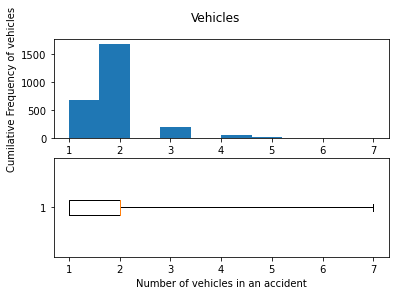

In [67]:
#Histogram and Boxplot for number_of_vehicles 
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(number_of_vehicles, 10);
ax2.boxplot(number_of_vehicles, showfliers= True, vert=False, whis = [0,100]);

ax1.set_xlabel('Number of vehicles in an accident');
ax1.set_ylabel('Cumilative Frequency of vehicles');


ax2.set_xlabel('Number of vehicles in an accident');

fig.suptitle('Vehicles');

### Number of Casualties

In [69]:
# Number_of_Casualties - Numerical
number_of_casualties = sorted(data_bir["accidents"]["Number_of_Casualties"])
quartiles_NOC = np.percentile(number_of_casualties, [25, 50, 75])

# calculate min/max
data_min_NOC, data_max_NOC = min(number_of_casualties), max(number_of_casualties)

# print 5-number summary
print('Min: %.3f' % data_min_NOC)
print('Q1: %.3f' % quartiles_NOC[0])
print('Median: %.3f' % quartiles_NOC[1])
print('Q3: %.3f' % quartiles_NOC[2])
print('Max: %.3f' % data_max_NOC)

Min: 1.000
Q1: 1.000
Median: 1.000
Q3: 1.000
Max: 8.000


<Figure size 360x360 with 0 Axes>

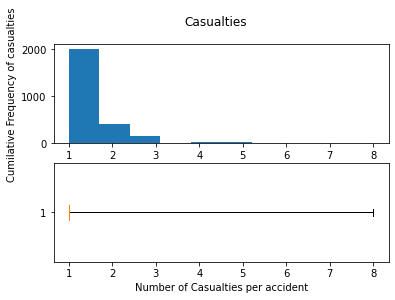

In [71]:
#Histogram and Boxplot for number_of_casualties 
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(number_of_casualties, 10);
ax2.boxplot(number_of_casualties, showfliers= True, vert=False, whis = [0, 100]);

ax1.set_xlabel('Number of Casualties per accident');
ax1.set_ylabel('Cumilative Frequency of casualties');


ax2.set_xlabel('Number of Casualties per accident');

fig.suptitle('Casualties');
                      

### Age of Driver

In [72]:
# Age_of_Driver - Numerical
age_of_driver = sorted(clean_AOD_accidents["Age_of_Driver"])
quartiles_AOD = np.percentile(age_of_driver, [25, 50, 75])

# calculate min/max
data_min_AOD, data_max_AOD = min(age_of_driver), max(age_of_driver)

# print 5-number summary
print('Min: %.3f' % data_min_AOD)
print('Q1: %.3f' % quartiles_AOD[0])
print('Median: %.3f' % quartiles_AOD[1])
print('Q3: %.3f' % quartiles_AOD[2])
print('Max: %.3f' % data_max_AOD)

Min: 3.000
Q1: 27.000
Median: 36.000
Q3: 48.000
Max: 93.000


<Figure size 360x360 with 0 Axes>

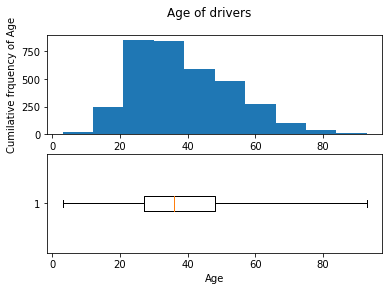

In [73]:
#Histogram and Boxplot for age_of_driver
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(age_of_driver, 10);
ax2.boxplot(age_of_driver, showfliers= False, vert=False, whis = [0,100]);

ax1.set_xlabel('Age');
ax1.set_ylabel('Cumilative frquency of Age');


ax2.set_xlabel('Age');

fig.suptitle('Age of drivers');

### Engine Capacity

In [74]:
# Engine_Capacity_(CC) - Numerical 

#using the data from clean_EC_vehicles

engine_capacity = sorted(clean_EC_vehicles["Engine_Capacity_CC"])
quartiles_EC = np.percentile(engine_capacity, [25, 50, 75])

# calculate min/max
data_min_EC, data_max_EC = min(engine_capacity), max(engine_capacity)

# print 5-number summary
print('Min: %.3f' % data_min_EC)
print('Q1: %.3f' % quartiles_EC[0])
print('Median: %.3f' % quartiles_EC[1])
print('Q3: %.3f' % quartiles_EC[2])
print('Max: %.3f' % data_max_EC)

Min: 49.000
Q1: 1360.000
Median: 1598.000
Q3: 1988.000
Max: 12902.000


<Figure size 360x360 with 0 Axes>

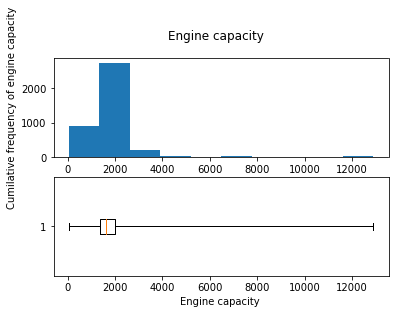

In [75]:
#Histogram and Boxplot for engine_capacity
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(engine_capacity, 10);
ax2.boxplot(engine_capacity, showfliers= False, vert=False, whis= [0,100]);

ax1.set_xlabel('Engine capacity');
ax1.set_ylabel('Cumilative frequency of engine capacity');

ax2.set_xlabel('Engine capacity ');

fig.suptitle('Engine capacity');

### Age of Vehicle

In [81]:
# Age_of_Vehicle - Numerical

#using the data from clean_AOV_vehicles

age_of_vehicle = sorted(clean_AOV_vehicles["Age_of_Vehicle"])
quartiles_AOV = np.percentile(age_of_vehicle, [25, 50, 75])

# calculate min/max
data_min_AOV, data_max_AOV = min(age_of_vehicle), max(age_of_vehicle)

# print 5-number summary
print('Min: %.3f' % data_min_AOV)
print('Q1: %.3f' % quartiles_AOV[0])
print('Median: %.3f' % quartiles_AOV[1])
print('Q3: %.3f' % quartiles_AOV[2])
print('Max: %.3f' % data_max_AOV)

Min: 1.000
Q1: 4.000
Median: 9.000
Q3: 12.000
Max: 36.000


<Figure size 360x360 with 0 Axes>

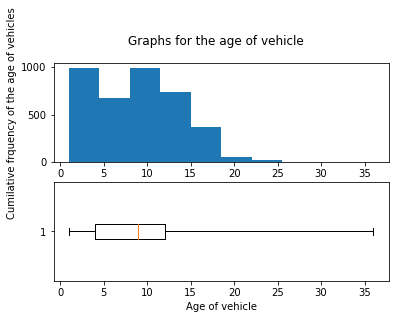

In [82]:
#Histogram and Boxplot for age_of_vehicle
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(age_of_vehicle, 10);
ax2.boxplot(age_of_vehicle, showfliers= False, vert=False, whis= [0,100]);

ax1.set_xlabel('Age of vehicle');
ax1.set_ylabel('Cumilative frquency of the age of vehicles');

ax2.set_xlabel('Age of vehicle');

fig.suptitle('Graphs for the age of vehicle');

### Age of Casualty

In [79]:
# Age_of_Casualty - Numerical

# using the data from clean_AOC_casualties

age_of_casualty = sorted(clean_AOC_casualties["Age_of_Casualty"])
quartiles_AOC = np.percentile(age_of_casualty, [25, 50, 75])

# calculate min/max
data_min_AOC, data_max_AOC = min(age_of_casualty), max(age_of_casualty)

# print 5-number summary
print('Min: %.3f' % data_min_AOC)
print('Q1: %.3f' % quartiles_AOC[0])
print('Median: %.3f' % quartiles_AOC[1])
print('Q3: %.3f' % quartiles_AOC[2])
print('Max: %.3f' % data_max_AOC)

Min: 1.000
Q1: 22.000
Median: 32.000
Q3: 46.000
Max: 94.000


<Figure size 360x360 with 0 Axes>

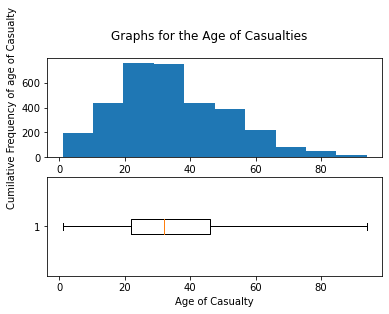

In [80]:
#Histogram and Boxplot for age_of_casualty
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(age_of_casualty, 10);
ax2.boxplot(age_of_casualty, showfliers= False, vert=False, whis=[0,100]);

ax1.set_xlabel('Age of Casualty');
ax1.set_ylabel('Cumilative Frequency of age of Casualty');


ax2.set_xlabel('Age of Casualty');

fig.suptitle('Graphs for the Age of Casualties');